In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from pprint import pprint
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=True

In [3]:
# 加载数据
data = []
feature_method = ['CHI','IG','MI']
is_inter = ['False','True']
for f in feature_method:
    for inter in is_inter:
        data.append(np.load('./np_cluster_pro/np_{}_{}.npy'.format(f,inter)))

In [9]:
# 去除数据中的最后一列，获得用于聚类的数据
def split_data(data):
    return data[:,0:-1]

def standard_data(data):
    print('data:{}'.format(data.shape))
    scaler = StandardScaler()
    np1 = scaler.fit_transform(data[:,0:2])
    np2 = data[:,2:4]
    np3 = scaler.fit_transform(data[:,4:])
    ans = np.hstack((np1,np2,np3))
    print('scale_data:{}'.format(ans.shape))
    return ans

In [12]:
code = {
    0:'CHI(without Interpolation)',
    1:'CHI(with Interpolation)',
    2:'IG(without Interpolation)',
    3:'IG(with Interpolation)',
    4:'MI(without Interpolation)',
    5:'MI(with Interpolation)',
}
k_arr = [20,20,15,15,15,15]
score = {}
for idx,data_item in enumerate(data):
    print('-----{}-----'.format(idx))
    cluster_data = split_data(data_item)
    cluster_data = standard_data(cluster_data)
    print('cluster_data:{}'.format(cluster_data.shape))
    score[code[idx]] = {}
    model = KMeans(n_clusters=k_arr[idx],init='k-means++',max_iter=4000).fit(cluster_data)
    score[code[idx]]['SC'] = silhouette_score(cluster_data,model.labels_)
    score[code[idx]]['CH'] = calinski_harabasz_score(cluster_data,model.labels_)
    score[code[idx]]['DB'] = davies_bouldin_score(cluster_data,model.labels_)

-----0-----
data:(3583, 94)
scale_data:(3583, 94)
cluster_data:(3583, 94)
-----1-----
data:(3583, 94)
scale_data:(3583, 94)
cluster_data:(3583, 94)
-----2-----
data:(3583, 94)
scale_data:(3583, 94)
cluster_data:(3583, 94)
-----3-----
data:(3583, 94)
scale_data:(3583, 94)
cluster_data:(3583, 94)
-----4-----
data:(3205, 94)
scale_data:(3205, 94)
cluster_data:(3205, 94)
-----5-----
data:(3205, 94)
scale_data:(3205, 94)
cluster_data:(3205, 94)


In [6]:
pprint(score)

{'CHI(with Interpolation)': {'CH': 665.9908825571243,
                             'DB': 1.342986384279811,
                             'SC': 0.17698742547658736},
 'CHI(without Interpolation)': {'CH': 580.7523033340054,
                                'DB': 1.3069966847988586,
                                'SC': 0.15547146484070676},
 'IG(with Interpolation)': {'CH': 747.0767114331713,
                            'DB': 1.3211181338366955,
                            'SC': 0.16528926159379906},
 'IG(without Interpolation)': {'CH': 667.893288847828,
                               'DB': 1.4473032843303533,
                               'SC': 0.12933825706847848},
 'MI(with Interpolation)': {'CH': 1201.0042247420183,
                            'DB': 1.1890873099406474,
                            'SC': 0.27408127723434994},
 'MI(without Interpolation)': {'CH': 1031.7752668439496,
                               'DB': 1.366168918385377,
                               'SC': 0.1764253324

In [18]:
ori_cluster_data = data[5]
print('---ori_cluster_data:{}'.format(ori_cluster_data.shape))
cluster_data = split_data(ori_cluster_data)
cluster_data = standard_data(cluster_data)
model = KMeans(n_clusters=15,init='k-means++',max_iter=4000).fit(cluster_data)

---ori_cluster_data:(3205, 95)
data:(3205, 94)
scale_data:(3205, 94)


In [19]:
labels = model.labels_
true_label = ori_cluster_data[:,-1]
len(labels)

3205

In [49]:
# 病区编码
coder = {
    1:'口腔科病区',
    2:'妇产科病区',
    3:'心血管病区',
    4:'整形外科病区',
    5:'普通外科病区',
    6:'普通胸外科病区',
    7:'泌尿外科中心病区',
    8:'眼科病区',
    9:'神经内科病区',
    10:'神经外科病区',
    11:'耳鼻咽喉科病区',
    12:'肝胆外科病区',
    13:'骨科病区'
}

def norm(cluster_info):
    np_arr = np.array(list(cluster_info.values()))
    return np_arr / np_arr.max()

def cal_dist(department_num1,department_num2):
    vector1 = norm(cluster_count[department_num1])
    vector2 = norm(cluster_count[department_num2])
#     print(vector1)
#     print(vector2)
    q = np.sum(vector1 * vector2)
    p = np.sqrt(np.sum(vector1 ** 2)) * np.sqrt(np.sum(vector2 ** 2))
    return round(q / p,4)

def gen_department_dist_matrix():
    department_list = [name for _,name in coder.items()]
    matrix = pd.DataFrame(index=department_list,columns=department_list)
    for i in range(1,14,1):
        for j in range(1,14,1):
            matrix.loc[coder[i],coder[j]] = cal_dist(i,j)
    return matrix

# 删除人数比较少的科室
def modify_matrix(mat):
    department_name = ['口腔科病区','整形外科病区','眼科病区','神经内科病区']
    ans = mat.copy()
    ans.drop(department_name,axis=0,inplace=True)
    ans.drop(department_name,axis=1,inplace=True)
    return ans

In [20]:
cluster_count = {}
for department in range(1,14,1):
    cluster_count[department] = {}
    for cluster_num in range(0,15,1):
        cluster_count[department][cluster_num] = 0
for idx,department in enumerate(true_label):
    cluster_count[department][labels[idx]] += 1
pprint(cluster_count)

{1: {0: 4,
     1: 45,
     2: 6,
     3: 1,
     4: 0,
     5: 0,
     6: 5,
     7: 24,
     8: 0,
     9: 1,
     10: 2,
     11: 0,
     12: 0,
     13: 0,
     14: 0},
 2: {0: 0,
     1: 250,
     2: 26,
     3: 1,
     4: 0,
     5: 3,
     6: 10,
     7: 300,
     8: 0,
     9: 0,
     10: 0,
     11: 0,
     12: 0,
     13: 0,
     14: 1},
 3: {0: 0,
     1: 66,
     2: 8,
     3: 167,
     4: 0,
     5: 0,
     6: 41,
     7: 1,
     8: 3,
     9: 0,
     10: 0,
     11: 20,
     12: 1,
     13: 30,
     14: 15},
 4: {0: 0,
     1: 9,
     2: 7,
     3: 0,
     4: 0,
     5: 0,
     6: 1,
     7: 2,
     8: 0,
     9: 0,
     10: 0,
     11: 0,
     12: 0,
     13: 0,
     14: 1},
 5: {0: 9,
     1: 191,
     2: 33,
     3: 0,
     4: 0,
     5: 0,
     6: 38,
     7: 42,
     8: 2,
     9: 0,
     10: 0,
     11: 0,
     12: 0,
     13: 0,
     14: 0},
 6: {0: 134,
     1: 49,
     2: 1,
     3: 0,
     4: 0,
     5: 0,
     6: 1,
     7: 3,
     8: 0,
     9: 0,
     10: 0,


In [50]:
dist_mat = gen_department_dist_matrix()
dist_mat

,口腔科病区,妇产科病区,心血管病区,整形外科病区,普通外科病区,普通胸外科病区,泌尿外科中心病区,眼科病区,神经内科病区,神经外科病区,耳鼻咽喉科病区,肝胆外科病区,骨科病区
口腔科病区,1,0.9198,0.3496,0.8276,0.9574,0.3819,0.4525,0.7449,0.6451,0.7109,0.3632,0.9362,0.9243
妇产科病区,0.9198,1,0.2385,0.6665,0.7782,0.236,0.3465,0.611,0.4878,0.559,0.3062,0.7481,0.7199
心血管病区,0.3496,0.2385,1,0.3221,0.3799,0.1238,0.1794,0.3507,0.3888,0.356,0.112,0.3609,0.3647
整形外科病区,0.8276,0.6665,0.3221,1,0.8789,0.2751,0.4046,0.6959,0.636,0.6457,0.298,0.8144,0.8442
普通外科病区,0.9574,0.7782,0.3799,0.8789,1,0.373,0.4619,0.7485,0.7066,0.7554,0.3301,0.979,0.983
普通胸外科病区,0.3819,0.236,0.1238,0.2751,0.373,1,0.1573,0.2527,0.2315,0.2584,0.1097,0.3417,0.3424
泌尿外科中心病区,0.4525,0.3465,0.1794,0.4046,0.4619,0.1573,1,0.9033,0.3294,0.3504,0.1507,0.5074,0.4555
眼科病区,0.7449,0.611,0.3507,0.6959,0.7485,0.2527,0.9033,1,0.5834,0.6263,0.2582,0.7828,0.7489
神经内科病区,0.6451,0.4878,0.3888,0.636,0.7066,0.2315,0.3294,0.5834,1,0.9846,0.2234,0.6814,0.6905
神经外科病区,0.7109,0.559,0.356,0.6457,0.7554,0.2584,0.3504,0.6263,0.9846,1,0.2483,0.7557,0.7586


In [51]:
dist_mat_drop = modify_matrix(dist_mat)
dist_mat_drop

,妇产科病区,心血管病区,普通外科病区,普通胸外科病区,泌尿外科中心病区,神经外科病区,耳鼻咽喉科病区,肝胆外科病区,骨科病区
妇产科病区,1,0.2385,0.7782,0.236,0.3465,0.559,0.3062,0.7481,0.7199
心血管病区,0.2385,1,0.3799,0.1238,0.1794,0.356,0.112,0.3609,0.3647
普通外科病区,0.7782,0.3799,1,0.373,0.4619,0.7554,0.3301,0.979,0.983
普通胸外科病区,0.236,0.1238,0.373,1,0.1573,0.2584,0.1097,0.3417,0.3424
泌尿外科中心病区,0.3465,0.1794,0.4619,0.1573,1,0.3504,0.1507,0.5074,0.4555
神经外科病区,0.559,0.356,0.7554,0.2584,0.3504,1,0.2483,0.7557,0.7586
耳鼻咽喉科病区,0.3062,0.112,0.3301,0.1097,0.1507,0.2483,1,0.3273,0.3261
肝胆外科病区,0.7481,0.3609,0.979,0.3417,0.5074,0.7557,0.3273,1,0.9954
骨科病区,0.7199,0.3647,0.983,0.3424,0.4555,0.7586,0.3261,0.9954,1


In [39]:
cal_dist(3,2)

[0.         0.39520958 0.04790419 1.         0.         0.
 0.24550898 0.00598802 0.01796407 0.         0.         0.11976048
 0.00598802 0.17964072 0.08982036]
[0.         0.83333333 0.08666667 0.00333333 0.         0.01
 0.03333333 1.         0.         0.         0.         0.
 0.         0.         0.00333333]


0.2385

In [47]:
dist_mat.to_excel('./np_cluster_pro/deparment_dist.xlsx')

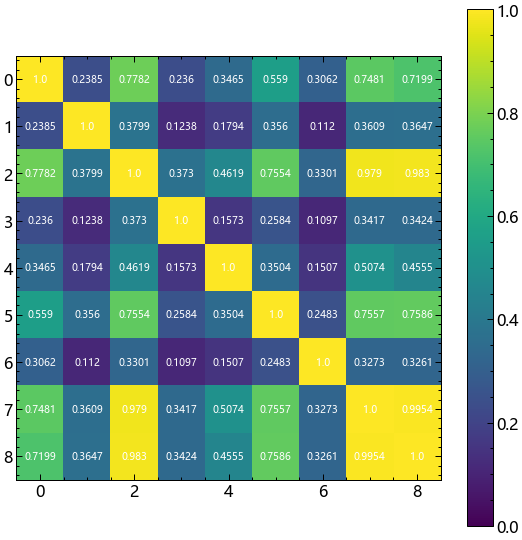

In [55]:
with plt.style.context(['science','notebook']):
    map_data = dist_mat_drop.values.astype(float)
    map_data = np.around(map_data,4)
#     plt.figure(figsize=(7.5,5.5),dpi=100)
    fig,ax = plt.subplots(figsize=(9.5,9.5))
    plt.imshow(map_data,vmin=0.0,vmax=1.0)
    for i in range(9):
        for j in range(9):
            text = ax.text(j,i,map_data[i,j],ha="center", va="center", color="w")
    plt.colorbar()
    plt.show()